packages

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt

from PIL import Image
import cv2

import torch
from torch import nn
from torch.functional import F
import torchvision
from torchvision import transforms

from importlib import reload

In [2]:
import cambridge
reload(cambridge)

import criterion
reload(criterion)

<module 'criterion' from 'c:\\Users\\82105\\Desktop\\PoseNet\\PoseNet\\criterion.py'>

meta-parameters

In [3]:
batch_size = 32
learning_rate = 1e-4
num_epochs = 3
image_height = 360#224
image_width = 480#224
beta = 300

device

In [4]:
# cuda or mps
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f"using {device} device")

using cpu device


logger

In [5]:
# logger
class AverageMeter():
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

transform

In [6]:
# basic transform
transform = transforms.Compose([
    transforms.Resize((image_height, image_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

dataset

In [7]:
# load dataset
dataset_root = '/Users/82105/Desktop/sample'
train_set = cambridge.CambridgeDataset(dataset_root, 'train', transform=transform)

# split train and val set
split_ratio = 0.8
seed = 42
torch.manual_seed(seed)
train_set, val_set = torch.utils.data.random_split(train_set, 
                                                   [int(len(train_set)*split_ratio), 
                                                    len(train_set)-int(len(train_set)*split_ratio)])


In [8]:
test_set = cambridge.CambridgeDataset(dataset_root, 'test', transform=transform)

dataloader

In [9]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

model

In [10]:
import models.eachnet
reload(models.eachnet)

model = models.eachnet.EachNet().to(device)

optimizer

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

training loop

In [12]:
loss_meter = AverageMeter()
tr_loss_meter = AverageMeter()
rot_loss_meter = AverageMeter()

train_loss_log = []
train_tr_loss_log = []
train_rot_loss_log = []
val_loss_log = []
val_tr_loss_log = []
val_rot_loss_log = []

In [13]:
total_step = len(train_loader)
visualize_step = total_step // 1 ################### 10

In [14]:
best_val_loss = 1e10

for epoch in range(num_epochs):

    for param_group in optimizer.param_groups:
        print('learing rage: ', param_group['lr'])

    # train
    model.train()
    print ('------------------- Train: Epoch [{}/{}] -------------------'.format(\
        epoch+1, num_epochs) )

    loss_meter.reset()
    tr_loss_meter.reset()
    rot_loss_meter.reset()

    for i, (image, target_tr, target_rot) in enumerate(train_loader):
        image = image.to(device)
        target_tr = target_tr.to(device)
        target_rot = target_rot.to(device)

        # Forward pass
        pred_tr, pred_rot = model(image)
        loss, tr_loss, rot_loss = criterion.compute_pose_loss(pred_tr, pred_rot, target_tr, target_rot,beta)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # logging
        loss_meter.update(loss.item(), image.size()[0] )
        tr_loss_meter.update(tr_loss.item(), image.size()[0] )
        rot_loss_meter.update(rot_loss.item(), image.size()[0] )

        if (i+1) % visualize_step == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Tr Loss: {:.4f}, Rot Loss: {:.4f}'.format(\
                epoch+1, num_epochs, i+1, total_step, loss.item(), tr_loss.item(), rot_loss.item() ) )

    print ('==> Train loss: {:.4f}'.format(loss_meter.avg),'tr loss: {:.4f}'.format(tr_loss_meter.avg),'rot loss: {:.4f}'.format(rot_loss_meter.avg) )

    train_loss_log.append(loss_meter.avg)
    train_tr_loss_log.append(tr_loss_meter.avg)
    train_rot_loss_log.append(rot_loss_meter.avg)

    # val
    model.eval() 
    print ('------------------- Val: Epoch [{}/{}] -------------------'.format(\
        epoch+1, num_epochs) ) 
    
    loss_meter.reset()
    tr_loss_meter.reset()
    rot_loss_meter.reset()

    for i, (image, target_tr, target_rot) in enumerate(val_loader):
        image = image.to(device)
        target_tr = target_tr.to(device)
        target_rot = target_rot.to(device)

        # Forward pass
        pred_tr, pred_rot = model(image)
        loss, tr_loss, rot_loss = criterion.compute_pose_loss(pred_tr, pred_rot, target_tr, target_rot,beta)

        # logging
        loss_meter.update(loss.item(), image.size()[0] )
        tr_loss_meter.update(tr_loss.item(), image.size()[0] )
        rot_loss_meter.update(rot_loss.item(), image.size()[0] )

        if (i+1) % visualize_step == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Tr Loss: {:.4f}, Rot Loss: {:.4f}'.format(\
                epoch+1, num_epochs, i+1, total_step, loss.item(), tr_loss.item(), rot_loss.item() ) )
            
    print ('==> Val loss: {:.4f}'.format(loss_meter.avg),'tr loss: {:.4f}'.format(tr_loss_meter.avg),'rot loss: {:.4f}'.format(rot_loss_meter.avg) )

    val_loss_log.append(loss_meter.avg)
    val_tr_loss_log.append(tr_loss_meter.avg)
    val_rot_loss_log.append(rot_loss_meter.avg)

    # save model
    if loss_meter.avg < best_val_loss:
        best_val_loss = loss_meter.avg
        if not os.path.exists('checkpoint'):
            os.makedirs('checkpoint')
        torch.save(model.state_dict(), 'checkpoint/best.pth')

# save best model
if not os.path.exists('checkpoint/last.pth'):
    print('best model updated')
    checkpoint = {
        'model': torch.load('checkpoint/best.pth'),
        'optimizer': optimizer.state_dict(),
        'epoch': epoch,
        'loss': best_val_loss
    }
    torch.save(checkpoint, 'checkpoint/last.pth')
else:
    checkpoint = torch.load('checkpoint/last.pth')
    if checkpoint['loss'] > best_val_loss:
        print('best model updated')
        checkpoint = {
            'model': torch.load('checkpoint/best.pth'),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch,
            'loss': best_val_loss
        }
        torch.save(checkpoint, 'checkpoint/last.pth')


learing rage:  0.0001
------------------- Train: Epoch [1/3] -------------------
Epoch [1/3], Step [1/1], Loss: 174.0111, Tr Loss: 62.7729, Rot Loss: 0.3708
==> Train loss: 174.0111 tr loss: 62.7729 rot loss: 0.3708
------------------- Val: Epoch [1/3] -------------------
Epoch [1/3], Step [1/1], Loss: 48.3374, Tr Loss: 38.2290, Rot Loss: 0.0337
==> Val loss: 48.3374 tr loss: 38.2290 rot loss: 0.0337
learing rage:  0.0001
------------------- Train: Epoch [2/3] -------------------
Epoch [2/3], Step [1/1], Loss: 30.0265, Tr Loss: 15.2191, Rot Loss: 0.0494
==> Train loss: 30.0265 tr loss: 15.2191 rot loss: 0.0494
------------------- Val: Epoch [2/3] -------------------
Epoch [2/3], Step [1/1], Loss: 21.9944, Tr Loss: 18.4786, Rot Loss: 0.0117
==> Val loss: 21.9944 tr loss: 18.4786 rot loss: 0.0117
learing rage:  0.0001
------------------- Train: Epoch [3/3] -------------------
Epoch [3/3], Step [1/1], Loss: 7.8052, Tr Loss: 1.1139, Rot Loss: 0.0223
==> Train loss: 7.8052 tr loss: 1.1139 r

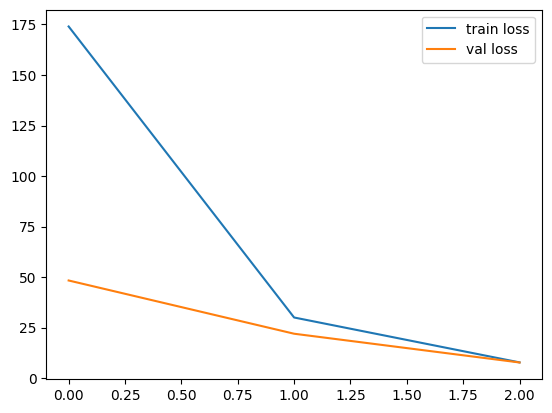

In [15]:
# plot losses
plt.plot(train_loss_log, label='train loss')
plt.plot(val_loss_log, label='val loss')
plt.legend()
plt.show()

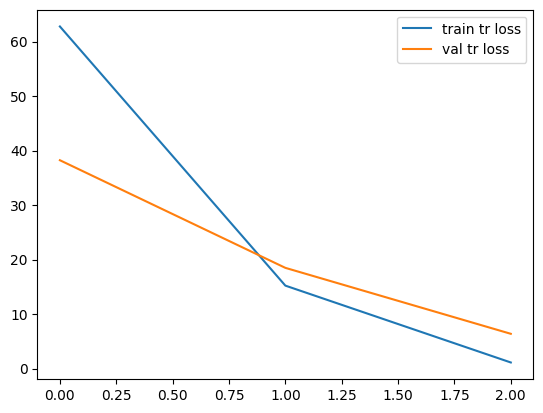

In [16]:
plt.plot(train_tr_loss_log, label='train tr loss')
plt.plot(val_tr_loss_log, label='val tr loss')
plt.legend()
plt.show()

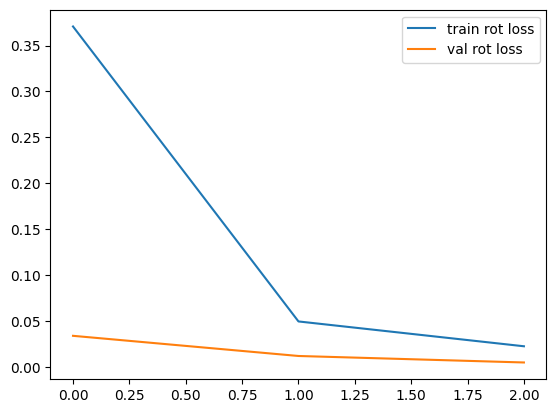

In [17]:
plt.plot(train_rot_loss_log, label='train rot loss')
plt.plot(val_rot_loss_log, label='val rot loss')
plt.legend()
plt.show()

In [18]:
import utils
reload(utils)

# load model
model_path = 'checkpoint/last.pth'

if os.path.exists(model_path):
    print(f"loading model from {model_path}")
    model.load_state_dict(torch.load(model_path)['model'])

# test

error_tr_meter = AverageMeter()
error_rot_meter = AverageMeter()

model.eval()
from tqdm import tqdm

for idx, (image, target_tr, target_rot) in tqdm(enumerate(test_set) ): 

    image = image.to(device)
    
    target_tr = target_tr.to(device)

    target_rot = target_rot.to(device)
    target_rot = F.normalize(target_rot, p=2, dim=0)

    pred_tr, pred_rot = model(image.unsqueeze(0)) 

    pred_tr = pred_tr.squeeze(0)

    pred_rot = pred_rot.squeeze(0)
    pred_rot = F.normalize(pred_rot, p=2, dim=0)

    pred_rot = pred_rot.cpu().detach().numpy()
    target_rot = target_rot.cpu().detach().numpy()

    pred_tr = pred_tr.cpu().detach().numpy()
    target_tr = target_tr.cpu().detach().numpy()

#    pred_rot = utils.quat_to_euler(pred_rot)
#    target_rot = utils.quat_to_euler(target_rot)
    
    error_tr = utils.position_dist(pred_tr, target_tr)
    error_rot = utils.rotation_dist(pred_rot, target_rot)

    error_tr_meter.update(error_tr)
    error_rot_meter.update(error_rot)

print(f"error_tr: {error_tr_meter.avg}")
print(f"error_rot: {error_rot_meter.avg}")

loading model from checkpoint/last.pth


2it [00:00,  2.63it/s]

error_tr: 2.7756826877593994
error_rot: 0.4948091327773344
